# Assignment 4 - Neural Networks

## *Jiechen Li*
Netid: jl1254

*Names of students you worked with on this assignment*: Lin Hui, Yabei Zeng, ChatGPT for concepts, machine learning python code, formula clarification and grammar check.

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://kylebradbury.github.io/ids705/notebooks/assignment_instructions.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

# 1

## [60 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [1]:
# Optional for clear plotting on Macs
%config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with
#  what's causing the warning and simply don't want to see it, we can use the
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
import numpy as np
from sklearn.model_selection import PredefinedSplit


# -----------------------------------------------------------------------------
# Create the data
# -----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n / 4)
    shift = 0.5
    c1a = np.random.randn(n_samples, 2) * noise + [-shift, shift]
    c1b = np.random.randn(n_samples, 2) * noise + [shift, -shift]
    c0a = np.random.randn(n_samples, 2) * noise + [shift, shift]
    c0b = np.random.randn(n_samples, 2) * noise + [-shift, -shift]
    X = np.concatenate((c1a, c1b, c0a, c0b), axis=0)
    y = np.concatenate((np.ones(2 * n_samples), np.zeros(2 * n_samples)))

    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X) > cutoff
    for index, value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand() * 2.5 - 1.25
    return (X, y)


# Training datasets
np.random.seed(42)
noise = 0.45
X_train, y_train = make_data_normal_checkerboard(500, noise=noise)

# Validation and test data
X_val, y_val = make_data_normal_checkerboard(500, noise=noise)
X_test, y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1 * np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

To help get you started we should always begin by visualizing our training data, here's some code that does that:

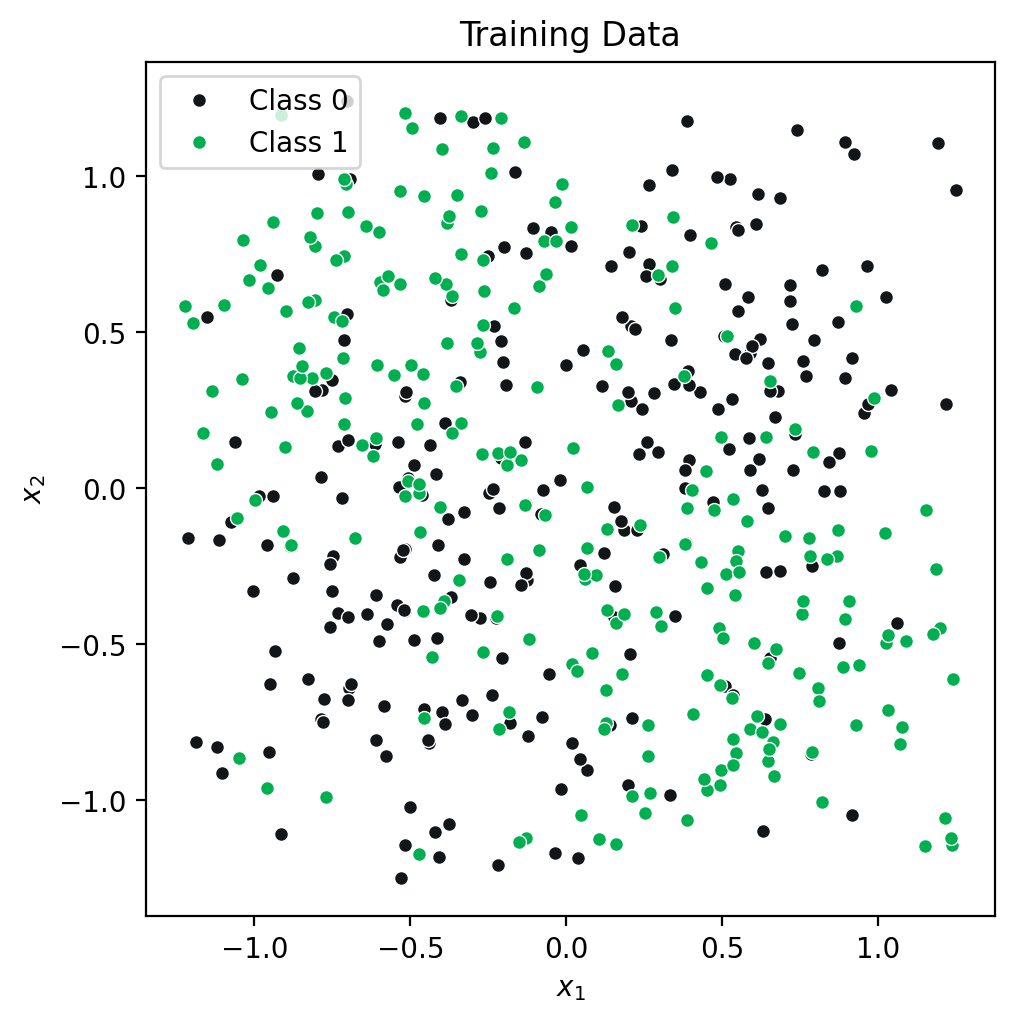

In [3]:
import matplotlib.pyplot as plt


# Code to plot the sample data
def plot_data(ax, X, y, title, limits):
    # Select the colors to use in the plots
    color0 = "#121619"  # Dark grey
    color1 = "#00B050"  # Green
    color_boundary = "#858585"

    # Separate samples by class
    samples0 = X[y == 0]
    samples1 = X[y == 1]

    ax.plot(
        samples0[:, 0],
        samples0[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 0",
    )
    ax.plot(
        samples1[:, 0],
        samples1[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 1",
    )
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.legend(loc="upper left")
    ax.set_aspect("equal")


fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, "Training Data", limits)

The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

This should produce 12 plots, altogether. For easier comparison, please plot nodes & layers combinations, learning rates, regularization strengths, and batch sizes in four separate rows (with three columns each representing a different value for each of those hyperparameters). 

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

## (a)

In [4]:
# first,train the MLPClassifier with the given hyperparameters

from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions


def train_and_plot_decision_boundary(
    X, y, hidden_layer_sizes, learning_rate_init, alpha, batch_size
):
    """Initialize the MLPClassifier with the given hyperparameters"""
    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=1000,
        batch_size=batch_size,
        max_iter=500,
        random_state=42,
    )

    # train the MLPClassifier
    clf.fit(X, y)

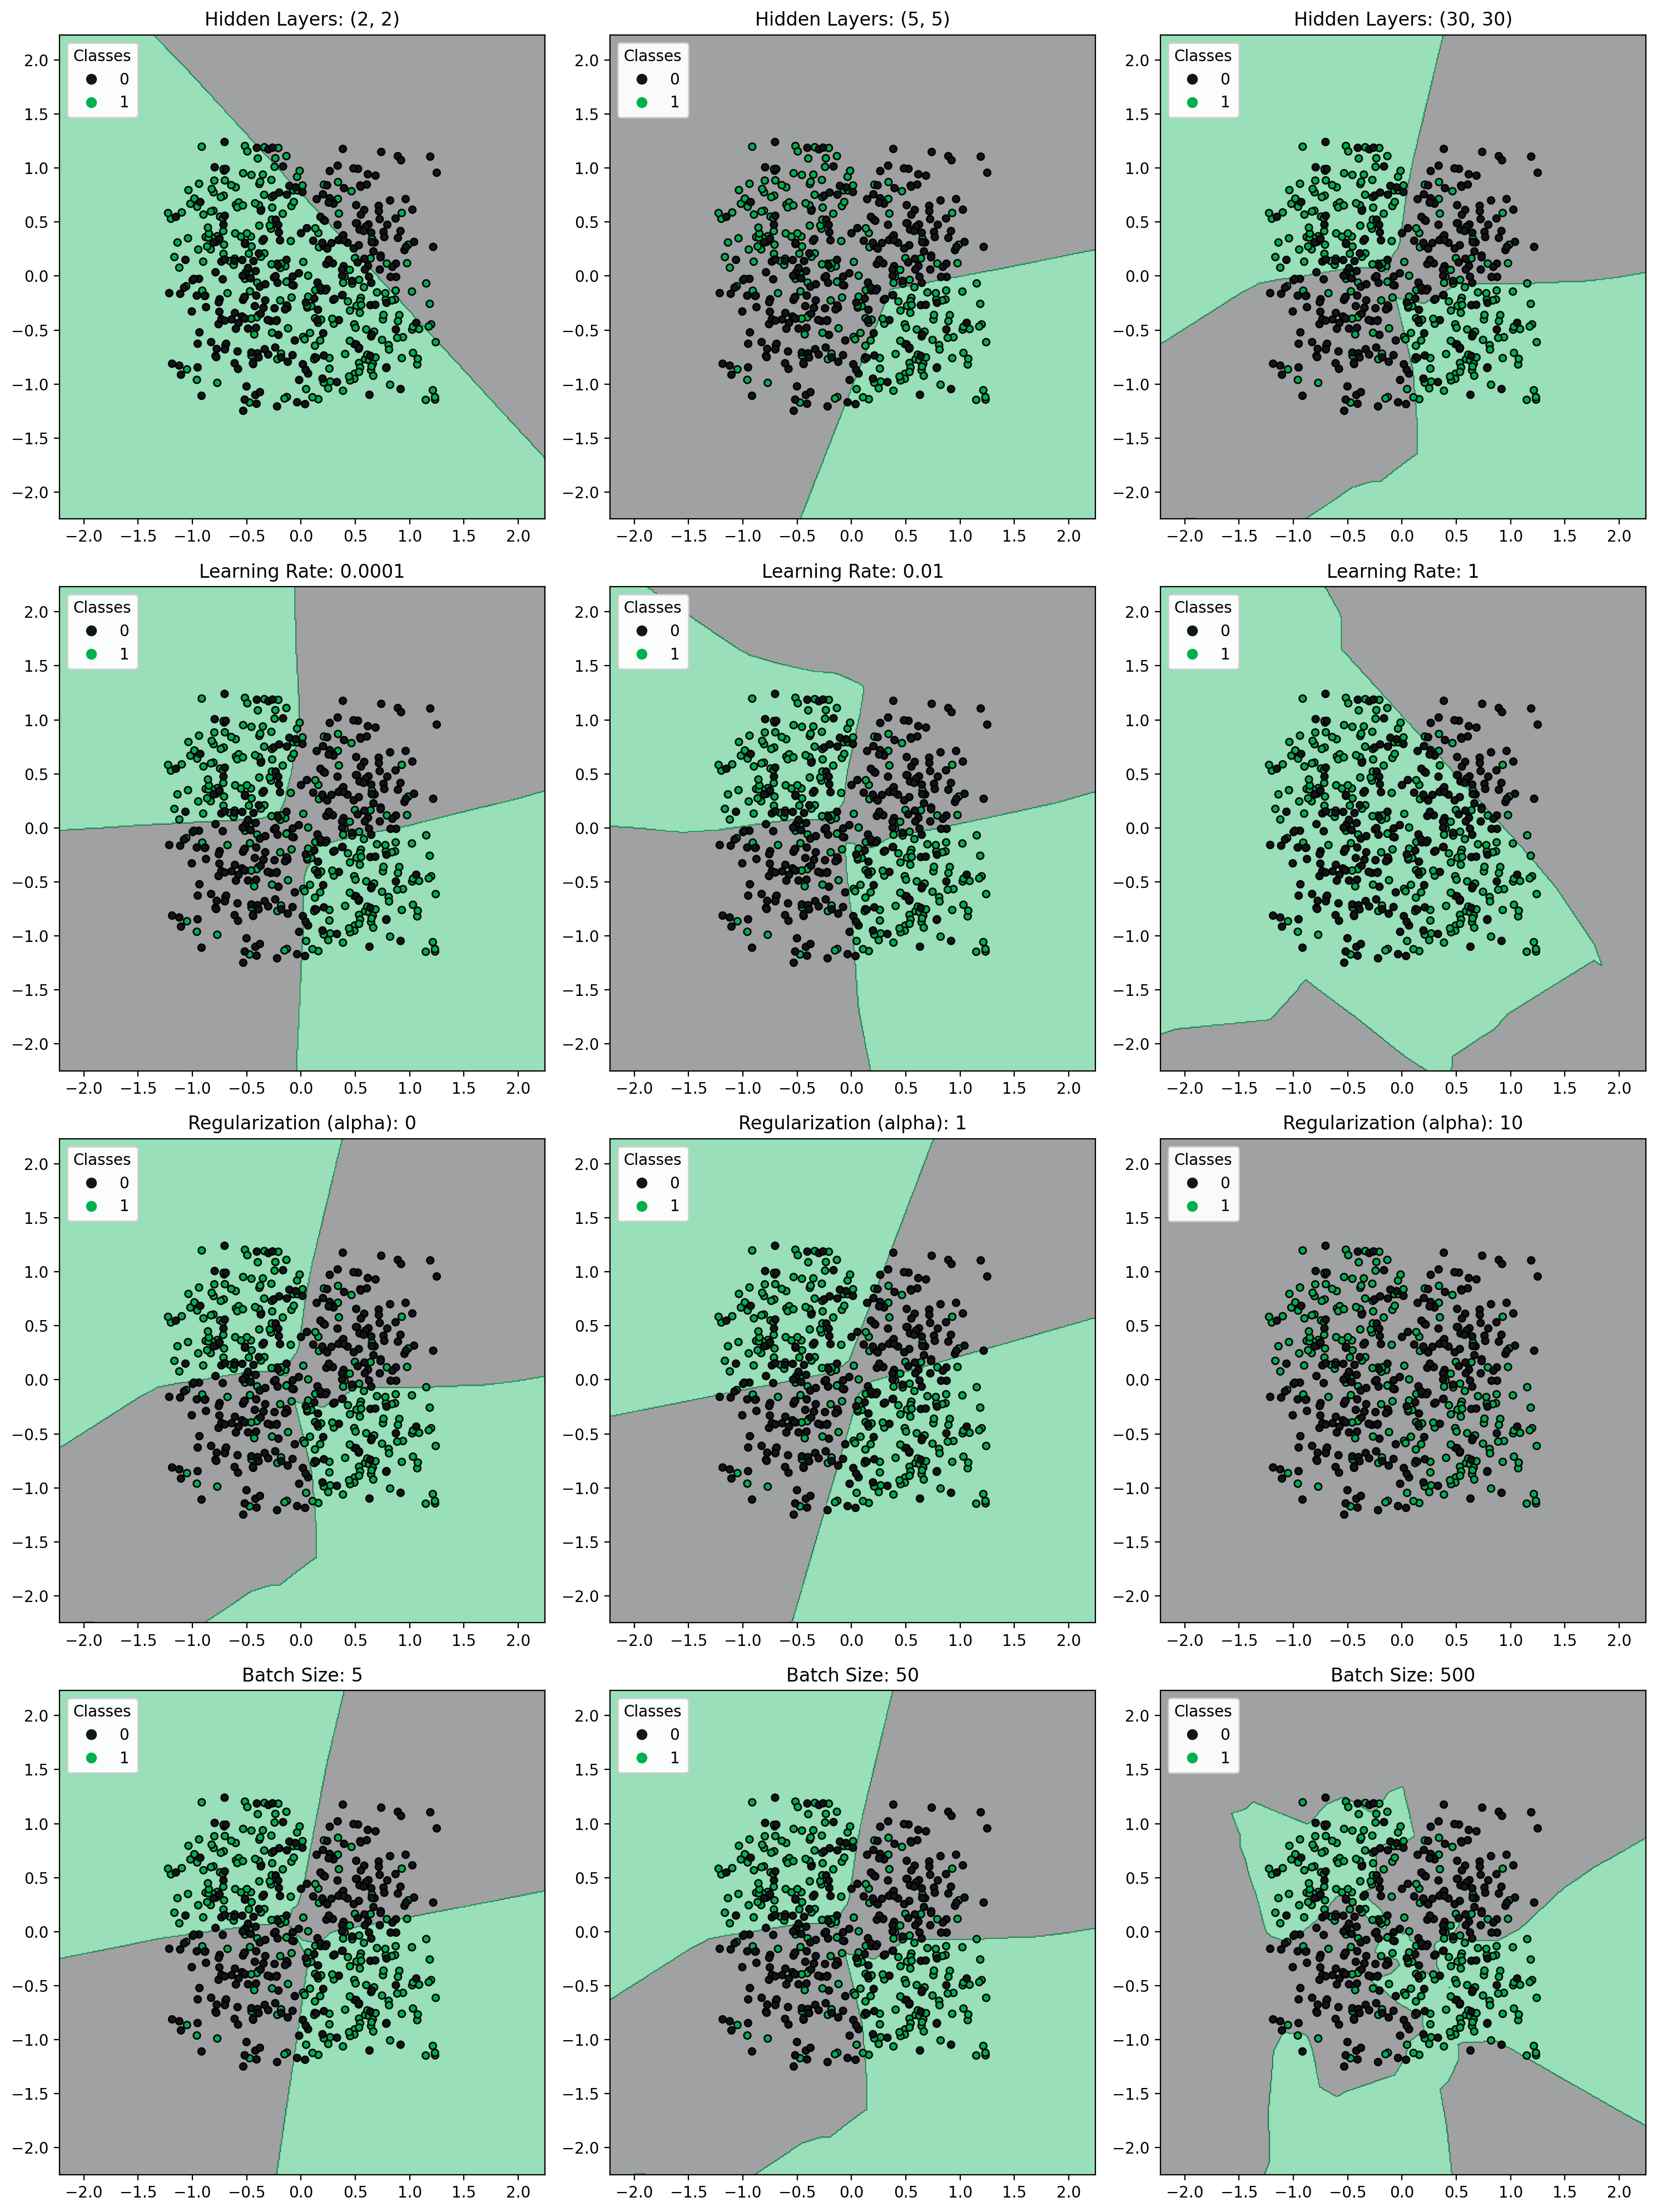

In [5]:
# 1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer
# while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X)
# means a 2-layer network with X nodes in each layer.

from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier


# Define the color with C map
color0 = "#121619"  # Dark grey
color1 = "#00B050"  # Green
color_map = ListedColormap([color0, color1])


# Function to plot decision boundary
def plot_decision_boundary(clf, X, y, ax, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    # Predict the function value for the whole grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=color_map)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k", cmap=color_map)

    # Create a legend for the scatter plot
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
    ax.add_artist(legend1)

    ax.set_title(title)


# Function to create a grid of subplots for different hyperparameter settings
def train_and_plot_grid(X_train, y_train):
    # Define hyperparameter settings
    hidden_layer_sizes_options = [(2, 2), (5, 5), (30, 30)]
    learning_rate_init_options = [0.0001, 0.01, 1]
    alpha_options = [0, 1, 10]
    batch_size_options = [5, 50, 500]

    # Set up the figure
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    axes = axes.ravel()  # Flatten the axes array

    # Default hyperparameters
    default_params = {
        "hidden_layer_sizes": (30, 30),
        "learning_rate_init": 0.03,
        "alpha": 0,
        "batch_size": 50,
        "max_iter": 500,
        "random_state": 42,
    }

    # Generate plots for each hyperparameter variation
    for i, size in enumerate(hidden_layer_sizes_options):
        params = default_params.copy()
        params["hidden_layer_sizes"] = size
        clf = MLPClassifier(**params).fit(X_train, y_train)
        plot_decision_boundary(clf, X_train, y_train, axes[i], f"Hidden Layers: {size}")

    for i, rate in enumerate(learning_rate_init_options):
        params = default_params.copy()
        params["learning_rate_init"] = rate
        clf = MLPClassifier(**params).fit(X_train, y_train)
        plot_decision_boundary(
            clf, X_train, y_train, axes[i + 3], f"Learning Rate: {rate}"
        )

    for i, alpha in enumerate(alpha_options):
        params = default_params.copy()
        params["alpha"] = alpha
        clf = MLPClassifier(**params).fit(X_train, y_train)
        plot_decision_boundary(
            clf, X_train, y_train, axes[i + 6], f"Regularization (alpha): {alpha}"
        )

    for i, batch in enumerate(batch_size_options):
        params = default_params.copy()
        params["batch_size"] = batch
        clf = MLPClassifier(**params).fit(X_train, y_train)
        plot_decision_boundary(
            clf, X_train, y_train, axes[i + 9], f"Batch Size: {batch}"
        )

    plt.tight_layout()
    plt.show()


# Generate and plot the data
np.random.seed(42)
noise = 0.45
X_train, y_train = make_data_normal_checkerboard(500, noise=noise)
train_and_plot_grid(X_train, y_train)

**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times (without fixing a random seed) and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

## (b)

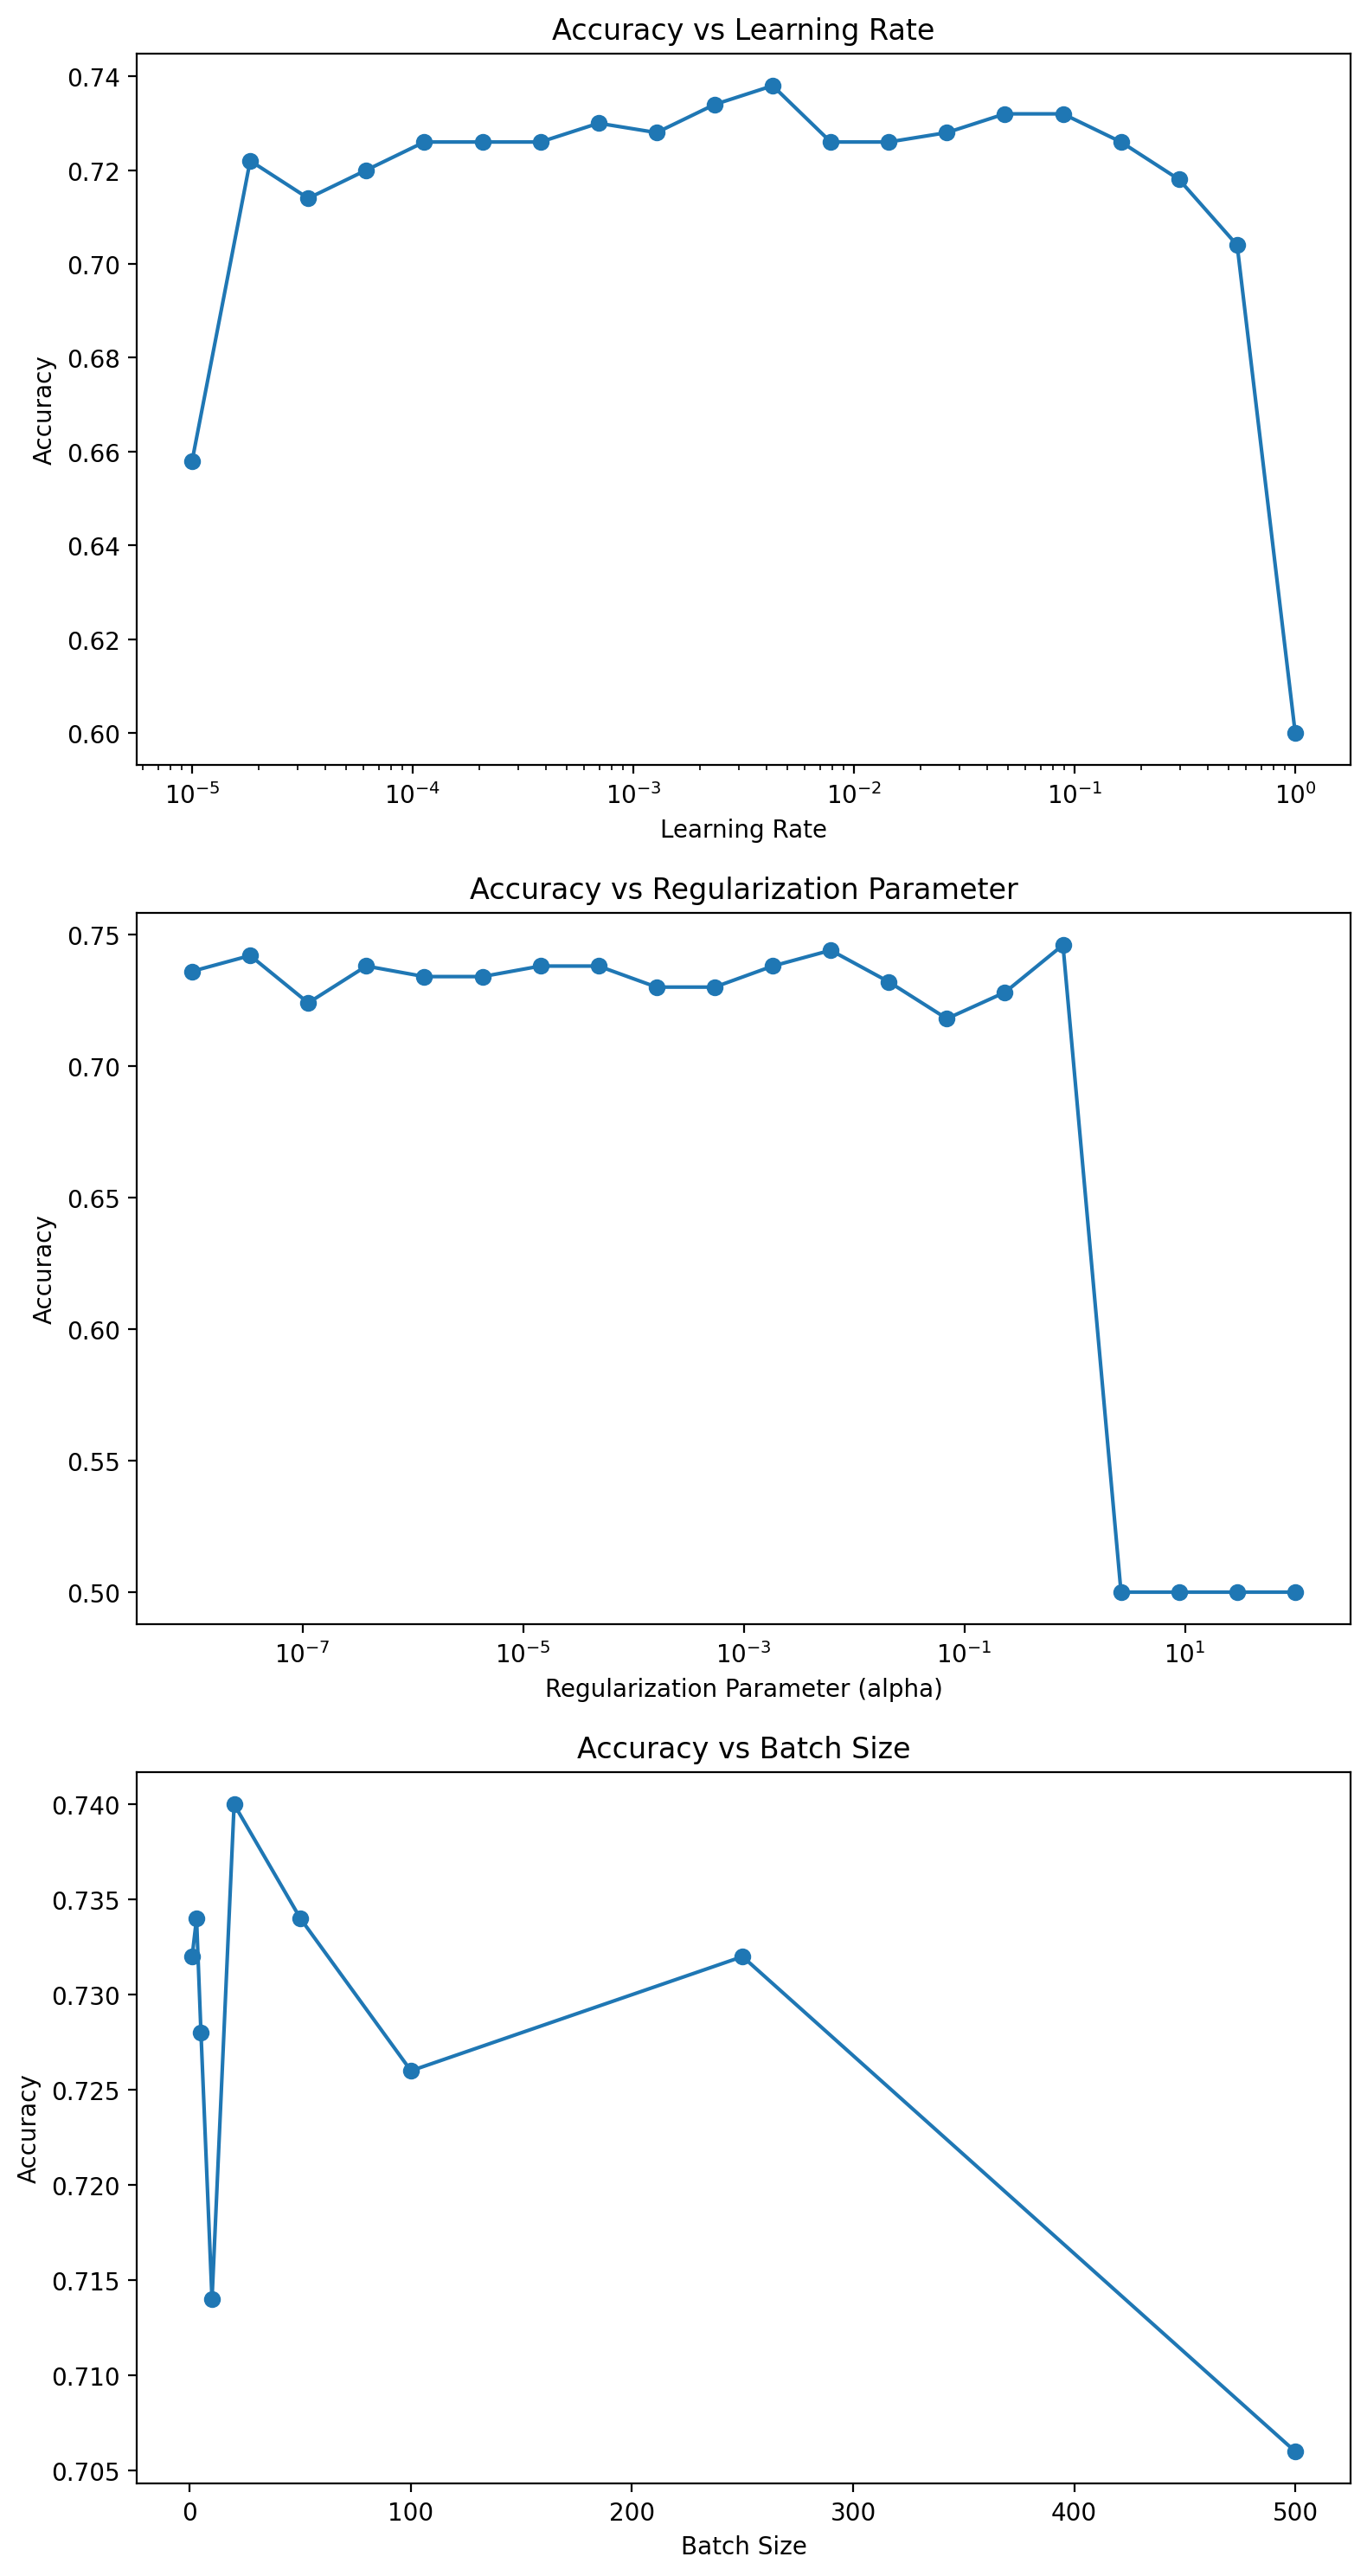

In [6]:
# Function to evaluate MLPClassifier over a range of hyperparameters
def evaluate_hyperparameter(
    hyperparam_name, hyperparam_values, X_train, y_train, X_val, y_val
):
    accuracies = []

    for value in hyperparam_values:
        params = {
            "hidden_layer_sizes": (30, 30),
            "learning_rate_init": 0.03,
            "alpha": 0,
            "batch_size": 50,
            "max_iter": 500,
            "random_state": 42,
        }
        params[hyperparam_name] = value
        clf = MLPClassifier(**params)
        clf.fit(X_train, y_train)
        score = clf.score(X_val, y_val)
        accuracies.append(score)

    return accuracies


# 1. Vary learning rate
learning_rates = np.logspace(-5, 0, 20)
accuracies_lr = evaluate_hyperparameter(
    "learning_rate_init", learning_rates, X_train, y_train, X_val, y_val
)

# 2. Vary regularization parameter
regularization_params = np.logspace(-8, 2, 20)
accuracies_reg = evaluate_hyperparameter(
    "alpha", regularization_params, X_train, y_train, X_val, y_val
)

# 3.  Vary batch size
batch_sizes = [1, 3, 5, 10, 20, 50, 100, 250, 500]
accuracies_batch = evaluate_hyperparameter(
    "batch_size", batch_sizes, X_train, y_train, X_val, y_val
)

# Plotting accuracies
fig, axes = plt.subplots(3, 1, figsize=(8, 15))
axes[0].plot(learning_rates, accuracies_lr, marker="o")
axes[0].set_xscale("log")
axes[0].set_title("Accuracy vs Learning Rate")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Accuracy")

axes[1].plot(regularization_params, accuracies_reg, marker="o")
axes[1].set_xscale("log")
axes[1].set_title("Accuracy vs Regularization Parameter")
axes[1].set_xlabel("Regularization Parameter (alpha)")
axes[1].set_ylabel("Accuracy")

axes[2].plot(batch_sizes, accuracies_batch, marker="o")
axes[2].set_title("Accuracy vs Batch Size")
axes[2].set_xlabel("Batch Size")
axes[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

> The learning rate plot shows hat accuracy peaks in the middle range of the learning rates and drops sharply as the learning rate approaches 1. The optimal learning rate appears to be around $10^{-2}$ where the accuracy plateaus before dropping. This value strikes a balance between convergence speed and stability. 

>The regularization parameter (alpha) plot shows a relativley stable accuracy as less than $10^{-1}$, and then there's a sharp decline as alpha increases. The best performance seems to be at a value just before the decline, which suggests that a small amount of regularization is beneficial but too much leads to underfitting. An optimal alpha could be around $10^{-3}$ to $10^{-2}$.

>The batch size plot shows the accuracy initially increases as the batch size goes up from 1, peaks around a batch size of 5, then generally decreases or remains stable with some fluctuations. Smaller batch sizes can lead to faster learning but can be noisy. A batch size of 5 is likely a good compromise between the benefits of stochasticity and the stability of larger batches.

>In this case, for the next steps in sections (c) and (d), we use the optimal hyperparameter with learning rate: $10^{-2}$ regularization parameter (alpha) between $10^{-3}$ to $10^{-2}$ and batch size as 5. These values should now be set as the new defaults when initializing the ``MLPClassifier`` for further analysis and training.

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

## (c)

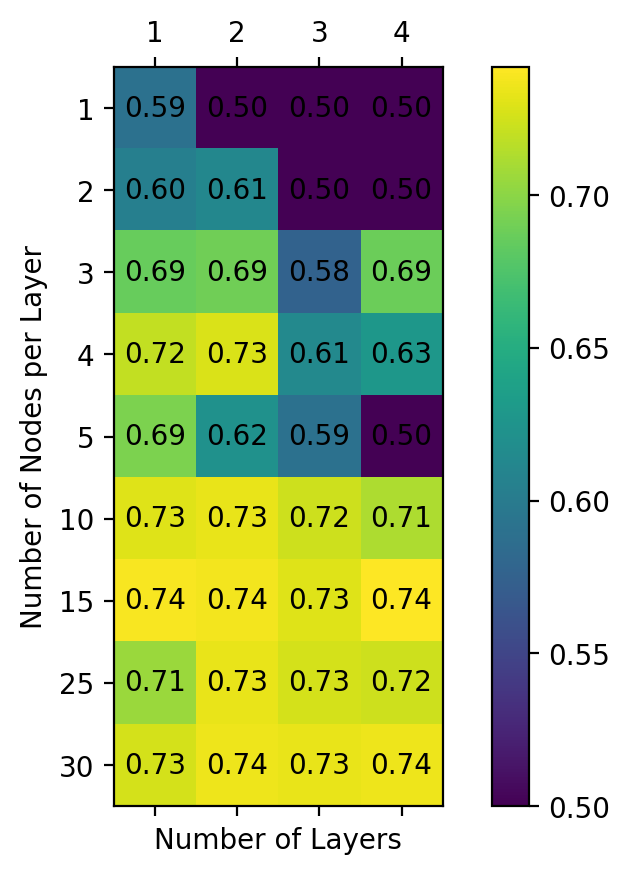

In [7]:
# Optimized hyperparameters from section (b)
optimized_learning_rate = 1e-2
optimized_alpha = 1e-3
optimized_batch_size = 5

# Possible numbers of nodes per layer and number of layers
nodes_per_layer_options = [1, 2, 3, 4, 5, 10, 15, 25, 30]
number_of_layers_options = [1, 2, 3, 4]

# Store the accuracy for each configuration
accuracy_results = np.zeros(
    (len(nodes_per_layer_options), len(number_of_layers_options))
)

# Evaluate each architecture
for i, nodes_per_layer in enumerate(nodes_per_layer_options):
    for j, number_of_layers in enumerate(number_of_layers_options):
        hidden_layer_sizes = (nodes_per_layer,) * number_of_layers
        clf = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            learning_rate_init=optimized_learning_rate,
            alpha=optimized_alpha,
            batch_size=optimized_batch_size,
            max_iter=500,
            random_state=42,
        )
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_val, y_val)
        accuracy_results[i][j] = accuracy

# Create a heatmap
fig, ax = plt.subplots()
cax = ax.matshow(accuracy_results, cmap="viridis")

# Add color bar
fig.colorbar(cax)

# Add numbers to the squares
for i in range(len(nodes_per_layer_options)):
    for j in range(len(number_of_layers_options)):
        ax.text(j, i, f"{accuracy_results[i][j]:.2f}", va="center", ha="center")

# Set axis labels
ax.set_xticklabels([""] + number_of_layers_options)
ax.set_yticklabels([""] + nodes_per_layer_options)
ax.set_xlabel("Number of Layers")
ax.set_ylabel("Number of Nodes per Layer")

plt.show()

>The optimal model architecture based on the heatmap is one with 1 layer and 15 nodes, as it achieves the highest observed accuracy of 0.74 while maintaining simplicity. This choice aligns with Occam's razor, preferring the least complex model that still delivers high performance. The one-layer, 15-node configuration minimizes the total number of weights among the top-performing architectures, which helps in avoiding overfitting. Consequently, this model is selected for its balance between accuracy and simplicity.

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

## (d)

Accuracy on test data: 0.74


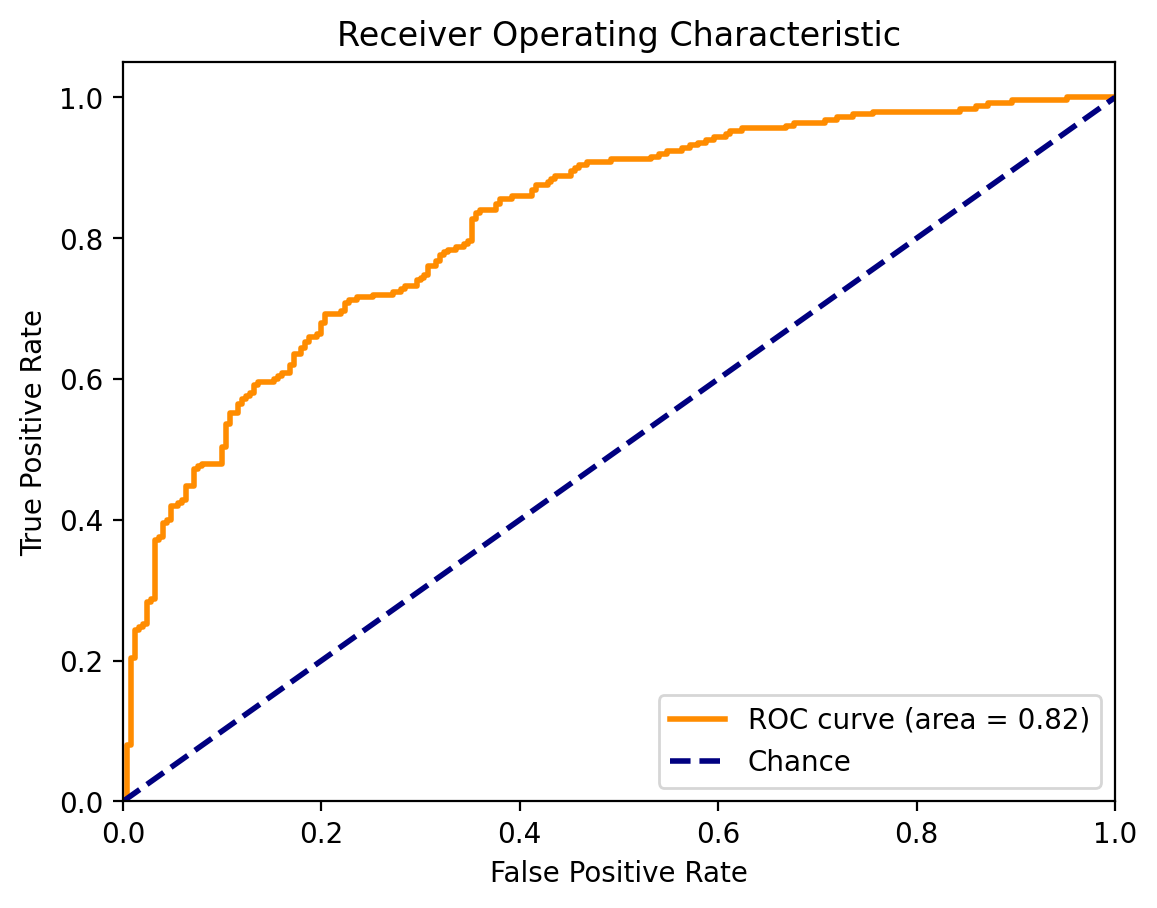

In [8]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# Hyperparameters
# 1 layer with 15 nodes from (c)
optimal_hidden_layer_sizes = (15,)
optimal_learning_rate = 1e-2
optimal_alpha = 1e-3
optimal_batch_size = 5

# Train the model
clf = MLPClassifier(
    hidden_layer_sizes=optimal_hidden_layer_sizes,
    learning_rate_init=optimal_learning_rate,
    alpha=optimal_alpha,
    batch_size=optimal_batch_size,
    max_iter=500,
)
clf.fit(X_train_plus_val, y_train_plus_val)

# Evaluate the model on the test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")

# Compute ROC curve and ROC area for the test data
y_score = clf.predict_proba(X_test)[:, 1]  # Get the probability for the positive class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this. 
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to. *Note: The object returned by running fit (the random search) is NOT the best estimator. You can access the best estimator through the attribute `.best_estimator_`, assuming that you did not pass `refit=False`.*
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve. This should be one single graph with 3 curves (one for greedy search, one for random search, and one representing random chance). Please also provide AUC score for greedy research and random search. 
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

## (e)

RandomizedSearchCV took 46.82 seconds for 200 candidate parameter settings.
Best Hyperparameters: {'alpha': 1.6626148525058852e-05, 'batch_size': 100, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.0004339970334001344}
Best Validation Score: 0.752
Test Accuracy on the test data: 0.74


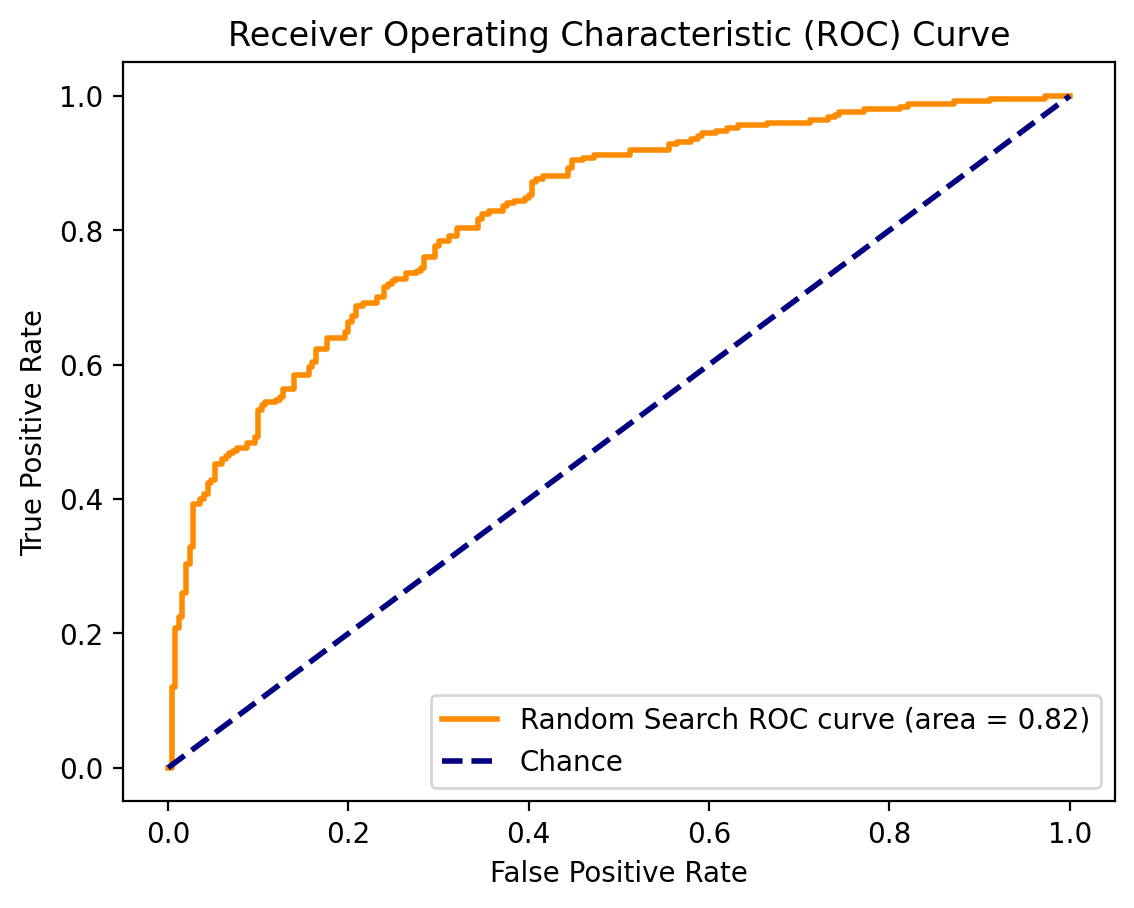

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from time import time

# Define the parameter distributions to sample from
param_distributions = {
    "hidden_layer_sizes": [
        (nodes,) * layers
        for nodes in [1, 2, 3, 4, 5, 10, 15, 25, 30]
        for layers in [1, 2, 3, 4]
    ],
    "learning_rate_init": loguniform(1e-5, 1e-0),
    "alpha": loguniform(1e-8, 1e2),
    "batch_size": [1, 3, 5, 10, 20, 50, 100, 250, 500],
}

# Initialize the MLPClassifier
clf = MLPClassifier(max_iter=500)

# Set up the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_distributions,
    n_iter=200,
    cv=train_val_split,
    n_jobs=-1,
    random_state=42,
)


# Function to report best scores from the search
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


# Perform the random search
start = time()
random_search.fit(X_train_plus_val, y_train_plus_val)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
    % ((time() - start), random_search.n_iter)
)

# Extract the best score from the random search results
best_score_index = random_search.cv_results_["rank_test_score"].argmin()
best_score = random_search.cv_results_["mean_test_score"][best_score_index]

# Extract the best hyperparameters and the best estimator
best_hyperparams = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Hyperparameters:", best_hyperparams)
print("Best Validation Score:", best_score)

# Evaluate on the test data
test_accuracy = best_estimator.score(X_test, y_test)
print("Test Accuracy on the test data: {:.2f}".format(test_accuracy))

# Compute ROC curve and ROC area for the test data
y_score = best_estimator.predict_proba(X_test)[
    :, 1
]  # Get the probability for the positive class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="Random Search ROC curve (area = {:.2f})".format(roc_auc),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

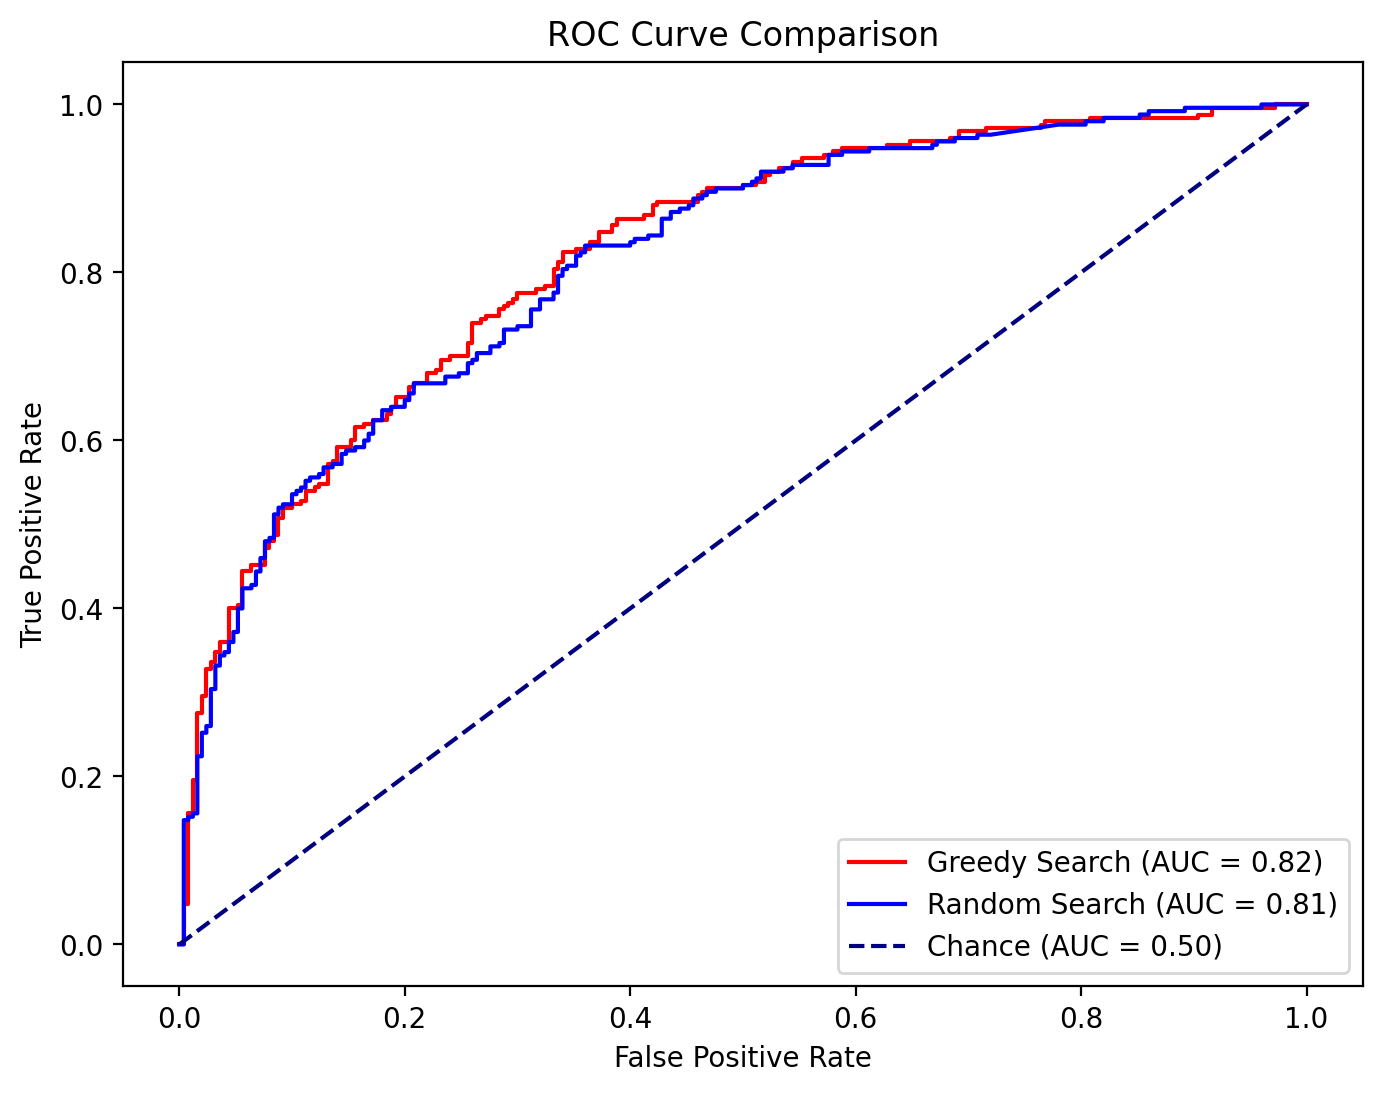

In [10]:
# One layer with 15 nodes
greedy_hyperparams = {
    "hidden_layer_sizes": (15,),
    "learning_rate_init": 0.01,
    "alpha": 0.001,
    "batch_size": "auto",  # Assuming default
    "max_iter": 500,
}

# Fit the model
best_estimator_greedy = MLPClassifier(**greedy_hyperparams)
best_estimator_greedy.fit(X_train_plus_val, y_train_plus_val)

random_hyperparams = {
    "alpha": 0.0022092000141089,
    "batch_size": 3,
    "hidden_layer_sizes": (4, 4),
    "learning_rate_init": 0.000447195646044396,
    "max_iter": 500,
}

# Fit the model
best_estimator_random = MLPClassifier(**random_hyperparams)
best_estimator_random.fit(X_train_plus_val, y_train_plus_val)


# Hypothetical predicted probabilities for the positive class
y_score_greedy = best_estimator_greedy.predict_proba(X_test)[:, 1]
y_score_random = best_estimator_random.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for greedy search
fpr_greedy, tpr_greedy, _ = roc_curve(y_test, y_score_greedy)
roc_auc_greedy = auc(fpr_greedy, tpr_greedy)

# Calculate ROC curve and AUC for random search
fpr_random, tpr_random, _ = roc_curve(y_test, y_score_random)
roc_auc_random = auc(fpr_random, tpr_random)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(
    fpr_greedy,
    tpr_greedy,
    color="red",
    label=f"Greedy Search (AUC = {roc_auc_greedy:.2f})",
)
plt.plot(
    fpr_random,
    tpr_random,
    color="blue",
    label=f"Random Search (AUC = {roc_auc_random:.2f})",
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

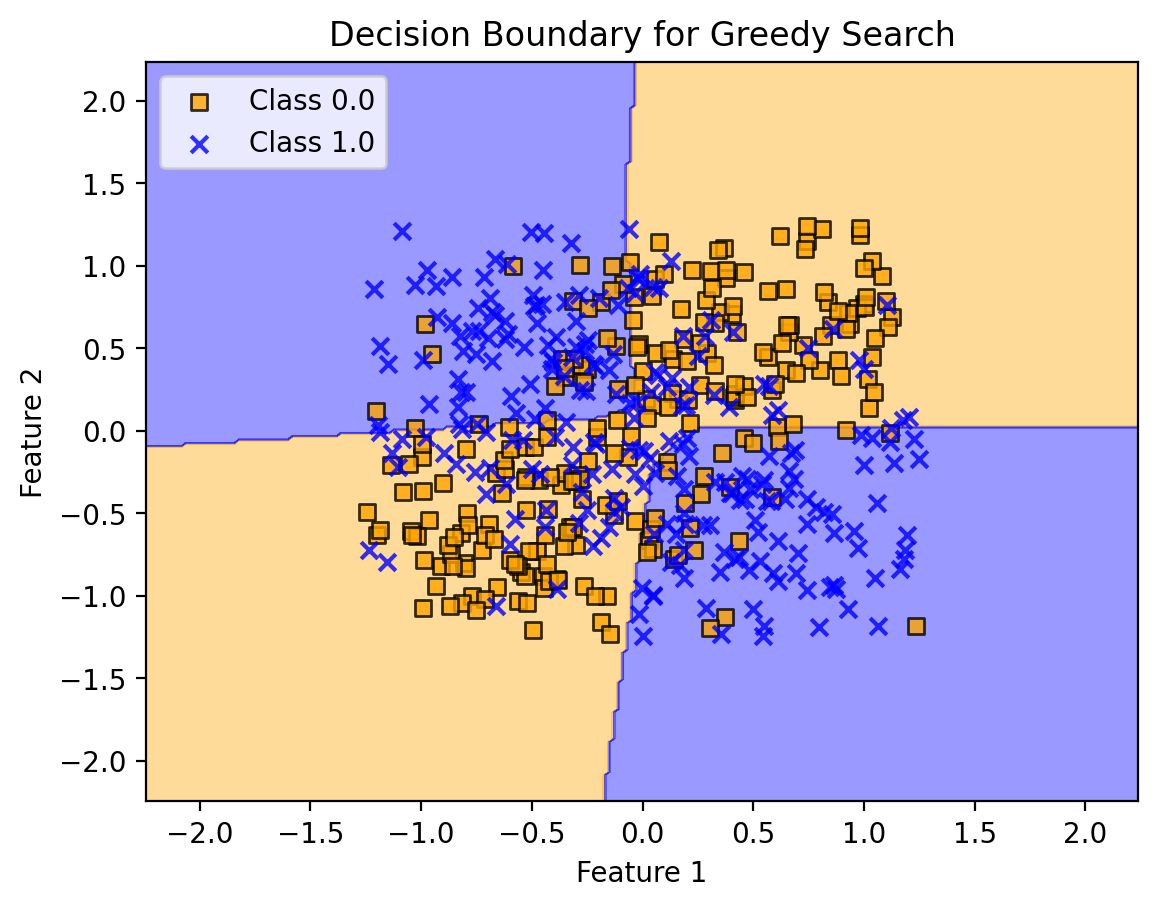

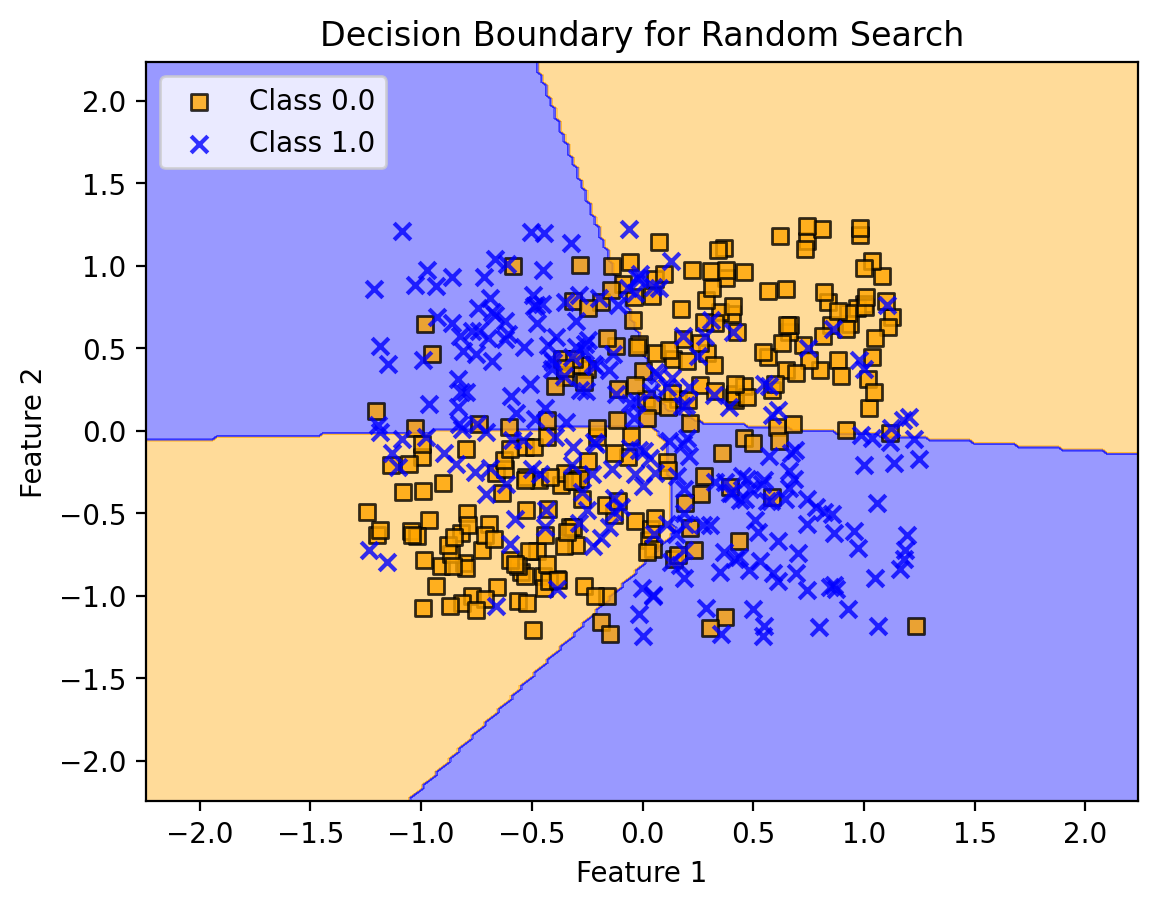

In [11]:
def plot_decision_boundary(classifier, X, y, title, resolution=0.02):
    # Setup marker generator and color map
    markers = ("s", "x", "o", "^", "v")
    colors = ("orange", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl}",
            edgecolor="black",
        )

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper left")
    plt.title(title)
    plt.show()


plot_decision_boundary(
    best_estimator_greedy, X_test, y_test, "Decision Boundary for Greedy Search"
)
plot_decision_boundary(
    best_estimator_random, X_test, y_test, "Decision Boundary for Random Search"
)

>Both the greedy and random search approaches yielded models with similar generalization performance on unseen test data, as evidenced by nearly identical ROC curves with AUC scores of 0.82 and 0.81, respectively. The decision boundary plots for both models suggest comparable abilities to separate classes within the feature space. Given the marginal difference in AUC scores, the model from the greedy search might have a slight advantage in distinguishing between classes, but overall, the performance of both models indicates that either hyperparameter tuning method can be effective for this dataset.

# 2

## [30 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a) [10 points of the 30]** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**NOTE: Due to the depth this question requires, some students may choose not to complete this section (in lieu of receiving the 10 points from this question). If you choose not to build your own neural network, or if your neural network is not functional prior to submission, then use the `scikit-learn` implementation instead in the questions below; where it asks to compare to `scikit-learn`, compare against a random forest classifier instead.**

## (a)

In [119]:
# neural network class skeleton code
class myNeuralNetwork(object):
    def __init__(self, n_in, n_layer1, n_layer2, n_out, learning_rate=0.01):
        """__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs,
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        """
        # initialize input
        self.n_in = n_in
        self.n_layer1 = n_layer1
        self.n_layer2 = n_layer2
        self.n_out = n_out
        self.learning_rate = learning_rate

        # initialize weights with small random values for each layer
        self.W1 = np.random.randn(self.n_in, self.n_layer1) * 0.01
        self.W2 = np.random.randn(self.n_layer1, self.n_layer2) * 0.01
        self.W_out = np.random.randn(self.n_layer2, self.n_out) * 0.01

        # initialize bias
        self.b1 = np.random.randn(1, self.n_layer1) * 0.01
        self.b2 = np.random.randn(1, self.n_layer2) * 0.01
        self.b_out = np.random.randn(1, self.n_out) * 0.01

    def forward_propagation(self, x):
        """forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        """
        # input to first hidden layer
        self.a1 = np.dot(x, self.W1) + self.b1
        self.z1 = self.sigmoid(self.a1)

        # first hidden layer to second hidden layer
        self.a2 = np.dot(self.z1, self.W2) + self.b2
        self.z2 = self.sigmoid(self.a2)

        # second hidden layer to output layer
        self.z_out = np.dot(self.z2, self.W_out) + self.b_out
        y_hat = self.sigmoid(self.z_out)  # final output prediction

        return y_hat

    def compute_loss(self, y, y_hat):
        """compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        """
        # compute the cross-entropy loss
        m = y.shape[0]  # number of samples
        loss = -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / m
        return loss

    def backpropagate(self, x, y):
        """backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations
               Corresponding to x and get the loss functionof the model
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network

            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        """

        # Step 1: Forward pass
        y_hat = self.forward_propagation(x)
        loss = self.compute_loss(y, y_hat)

        # Step 2: Backward pass to compute gradients
        # output layer to second hidden layer
        dLoss_yHat = y_hat - y
        dZ3 = dLoss_yHat * self.sigmoid_derivative(self.z_out)
        dW_out = np.dot(self.a2.T, dZ3) / y.shape[0]
        db_out = np.sum(dZ3, axis=0, keepdims=True) / y.shape[0]

        # second hidden layer to first hidden layer
        dA2 = np.dot(dLoss_yHat, self.W_out.T)
        dZ2 = dA2 * self.sigmoid_derivative(self.z2)
        dW2 = np.dot(self.a1.T, dZ2) / y.shape[0]
        db2 = np.sum(dZ2, axis=0, keepdims=True) / y.shape[0]

        # first hidden layer to input layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.z1)
        dW1 = np.dot(x.T, dZ1) / y.shape[0]
        db1 = np.sum(dZ1, axis=0, keepdims=True) / y.shape[0]

        # update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2
        self.W_out -= self.learning_rate * dW_out
        self.b1 -= self.learning_rate * db1
        self.b2 -= self.learning_rate * db2
        self.b_out -= self.learning_rate * db_out

        return loss

    # def stochastic_gradient_descent_step(self):
    #     """stochastic_gradient_descent_step [OPTIONAL - you may also do this
    #     directly in backpropagate]
    #     Using the gradient values computed by backpropagate, update each
    #     weight value of the model according to the familiar stochastic
    #     gradient descent update equation.

    #     Input: none
    #     Output: none
    #     """
    #     # Update weights and biases for each layer based on the
    #     # gradients computed in backpropagation and the learning rate
    #     # Calculate start and end indices for the current batch
    #     idx_start = self.cur_epoch_iter * self.batch_size
    #     idx_end = idx_start + self.batch_size

    #     # Safeguard for the last batch which might be smaller than batch_size
    #     idx_end = min(idx_end, len(self.X_train))

    #     # Extract the batch for X and y
    #     x_batch = self.X_train[self.idx[idx_start:idx_end]].T
    #     y_batch = self.y_train[:, self.idx[idx_start:idx_end]]

    #     # Backpropagation for the batch
    #     self.backpropagate(x_batch, y_batch)

    def fit(
        self,
        X,
        y,
        max_epochs=100,
        learning_rate=0.01,
        get_validation_loss=False,
        X_val=None,
        y_val=None,
    ):
        """fit
        Input:
            X: A matrix of N samples of data [N x n_in]
            y: Target variable [N x 1]
        Output:
            training_loss:   Vector of training loss values at the end of each epoch
            validation_loss: Vector of validation loss values at the end of each epoch
                             [optional output if get_validation_loss==True]
        """
        training_loss = []
        validation_loss = []
        self.learning_rate = learning_rate
        for epoch in range(max_epochs):
            # Initialize total loss for the epoch
            epoch_loss = 0

            # Iterate over individual samples
            for i in range(X.shape[0]):
                # Perform a forward pass and backpropagation
                x_sample = X[i].reshape(1, -1)  # Reshape to ensure it's a column vector
                y_sample = y[i].reshape(1, -1)
                loss = self.backpropagate(x_sample, y_sample)
                epoch_loss += loss
            # Average the loss over all samples and store it
            avg_epoch_loss = epoch_loss / X.shape[0]
            training_loss.append(avg_epoch_loss)

            # Optionally, compute validation loss
            if get_validation_loss and X_val is not None and y_val is not None:
                val_loss = 0
                for i in range(X_val.shape[0]):
                    y_hat = self.forward_propagation(X_val[i].reshape(1, -1))
                    val_loss += self.compute_loss(y_val[i].reshape(1, -1), y_hat)
                validation_loss.append(val_loss / X_val.shape[0])

            # Print progress
            print(
                f"Epoch {epoch+1}/{max_epochs}, Training Loss: {avg_epoch_loss}", end=""
            )
            if get_validation_loss:
                print(f", Validation Loss: {validation_loss[-1]}", end="")

        # Return the training and optionally validation loss
        return training_loss, validation_loss

    def predict_proba(self, X):
        """predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        """
        # Using list comprehension for a concise format
        y_hat = [self.forward_propagation(x.reshape(1, self.n_in)) for x in X]
        return np.array(y_hat).flatten()

    def predict(self, X, decision_thresh=0.5):
        """predict
        Compute the output of the neural network prediction for
        each sample in X, with the last layer's sigmoid activation
        providing an estimate of the target output between 0 and 1,
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        """
        # Directly using list comprehension and np.array for
        # conversion and condition application
        y_hat_proba = self.predict_proba(X)
        y_hat = np.array([1 if y >= decision_thresh else 0 for y in y_hat_proba])
        return y_hat

    def sigmoid(self, X):
        """sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        """
        # Our activation function: f(x) = 1 / (1 + e^(-x))
        return 1 / (1 + np.exp(-X))

    def sigmoid_derivative(self, X):
        """sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        """
        return self.sigmoid(X) * (1 - self.sigmoid(X))

**(b)** Apply your neural network. 
- Create training, validation, and test datasets using `sklearn.datasets.make_moons(N, noise=0.20)` data, where $N_{train} = 500$ and $N_{test} = 100$. The validation dataset should be a portion of your training dataset that you hold out for hyperparameter tuning.
- **Cost function plots**. Train and validate your model on this dataset plotting your training and validation cost learning curves on the same set of axes. This is the training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time. 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. You're free to use any methods you deem fit to tune your hyperparameters like grid search, random search, Bayesian optimization etc. 
- **Decision boundary plots**. In two subplots, plot the training data on one subplot and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- **ROC Curve plots**. Report your performance on the test data with an ROC curve and the corresponding AUC score. Compare against the `scikit-learn` `MLPClassifier` trained with the same parameters on the same set of axes and include the chance diagonal. *Note: if you chose not to build your own neural network in part (a) above, or if your neural network is not functional prior to submission, then use the `scikit-learn` `MLPClassifier` class instead for the neural network and compare it against a random forest classifier instead. Be sure to set the hidden layer sizes, epochs, and learning rate for that model, if so.*
- **Remember to retrain your model.** After selecting your hyperparameters using the validation data set, when evaluating the final performance on the ROC curve, it's good practice to retrain your model with the selected hyperparameters on the train + validation dataset, before evaluating on the test data. 

Note if you opted not to build your own neural network: in this case, for hyperparameter tuning, we recommend using the `partial_fit` method to train your model for every epoch. Partial fit allows you to incrementally fit on one sample at a time.



## (b)

In [120]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

N_train = 500
N_test = 100
X, y = make_moons(N_train, noise=0.20, random_state=42)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=N_test / N_train, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

Epoch 1/500, Training Loss: 0.6933302157706667, Validation Loss: 0.6929975834561446Epoch 2/500, Training Loss: 0.6931272418061554, Validation Loss: 0.6929079837167247Epoch 3/500, Training Loss: 0.6929934527356484, Validation Loss: 0.6928609116068806Epoch 4/500, Training Loss: 0.6929055950296545, Validation Loss: 0.6928399611869623Epoch 5/500, Training Loss: 0.6928481719871553, Validation Loss: 0.6928345789147969Epoch 6/500, Training Loss: 0.6928108684943634, Validation Loss: 0.6928380505181875Epoch 7/500, Training Loss: 0.6927868270370511, Validation Loss: 0.6928461671291084Epoch 8/500, Training Loss: 0.6927714953383177, Validation Loss: 0.6928563443568407Epoch 9/500, Training Loss: 0.6927618568160383, Validation Loss: 0.6928670424759331Epoch 10/500, Training Loss: 0.6927559170164004, Validation Loss: 0.6928773863061626Epoch 11/500, Training Loss: 0.6927523610563976, Validation Loss: 0.6928869172175649Epoch 12/500, Training Loss: 0.6927503252530266, Validation Loss: 0.6928954323371554E

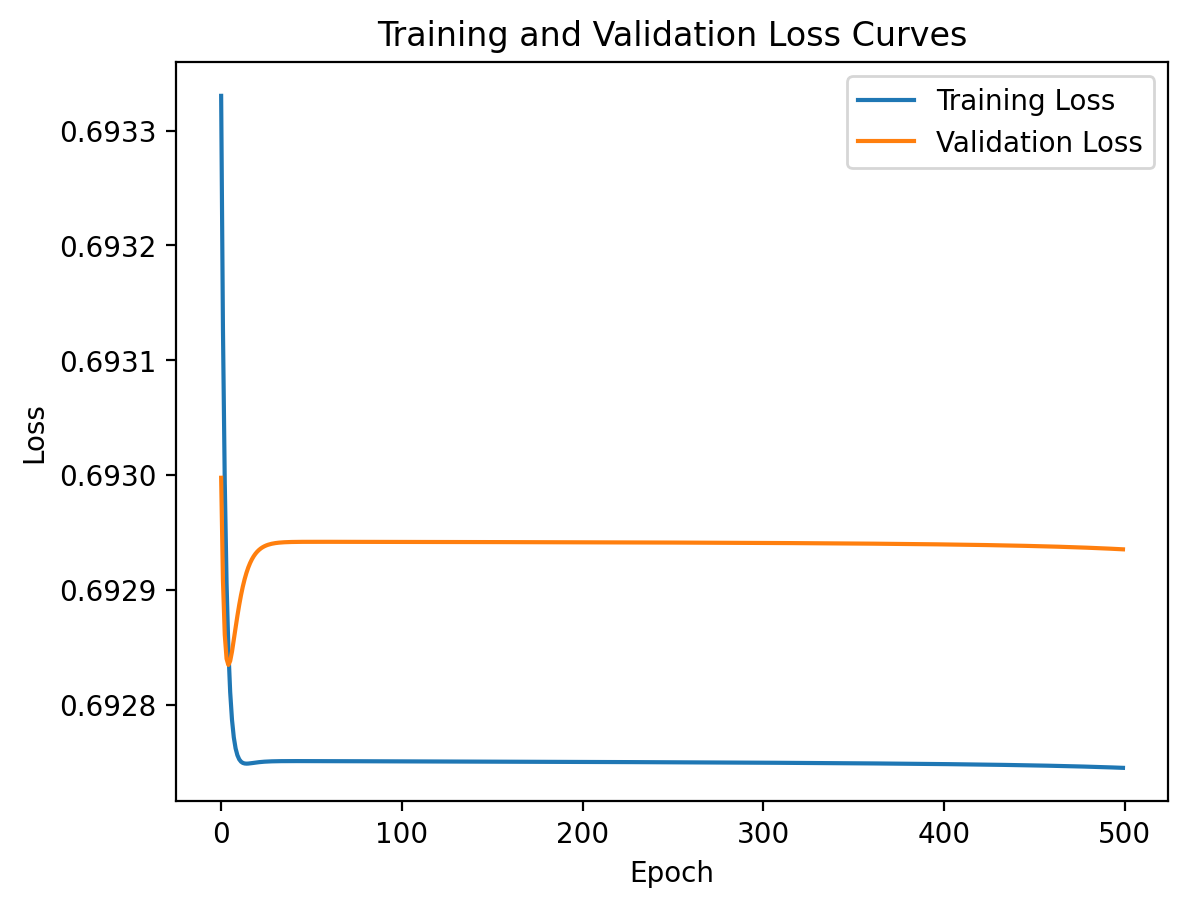

In [121]:
# 2. Train the Model and Plot Cost Function
# Initialize the neural network
import matplotlib.pyplot as plt

nn = myNeuralNetwork(n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=0.01)

# Train the model and collect training and validation losses
training_loss, validation_loss = nn.fit(
    X_train,
    y_train,
    max_epochs=500,
    learning_rate=0.01,
    get_validation_loss=True,
    X_val=X_val,
    y_val=y_val,
)

# Plotting the cost function

plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curves")
plt.show()

>The above model shows the result and plot with learning rate = 0.01, max_epoch = 500.

Epoch 1/100, Training Loss: 0.6936582183242088, Validation Loss: 0.6931640713978251Epoch 2/100, Training Loss: 0.6933426431012596, Validation Loss: 0.693001808598002Epoch 3/100, Training Loss: 0.6931347530114067, Validation Loss: 0.6929097228435497Epoch 4/100, Training Loss: 0.6929982129669934, Validation Loss: 0.6928614867418166Epoch 5/100, Training Loss: 0.6929088704056783, Validation Loss: 0.6928400841803694Epoch 6/100, Training Loss: 0.6928506897549849, Validation Loss: 0.6928346107832863Epoch 7/100, Training Loss: 0.6928130361873072, Validation Loss: 0.6928381557484047Epoch 8/100, Training Loss: 0.6927888649844369, Validation Loss: 0.6928464042693057Epoch 9/100, Training Loss: 0.6927735161671518, Validation Loss: 0.6928567182559158Epoch 10/100, Training Loss: 0.6927639126825851, Validation Loss: 0.6928675336547426Epoch 11/100, Training Loss: 0.6927580273077637, Validation Loss: 0.6928779668638909Epoch 12/100, Training Loss: 0.6927545283596992, Validation Loss: 0.6928875589440253Ep

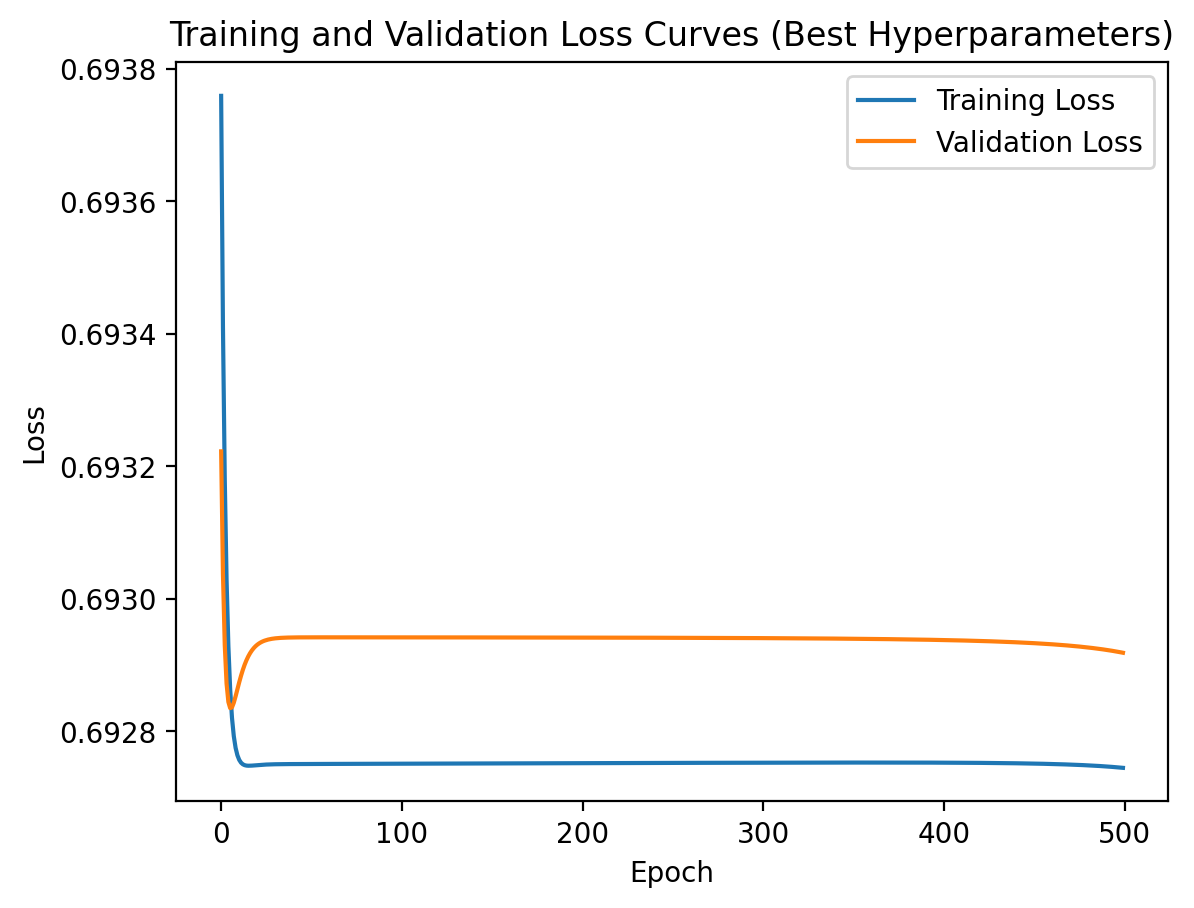

In [122]:
# find the best hyperparameters
# define a set of learning rates and epochs to explore
learning_rates = [0.01, 0.05, 0.1, 0.15]
epochs = [100, 300, 500, 800]

# initialize a dictionary to store validation losses for each combination
validation_losses = {}

# Loop through each combination of learning rate and epoch
for lr in learning_rates:
    for epoch in epochs:
        # initialize the neural network with the current learning rate
        nn = myNeuralNetwork(n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=lr)

        # train the model and collect training and validation losses
        training_loss, validation_loss = nn.fit(
            X_train,
            y_train,
            max_epochs=epoch,
            learning_rate=lr,
            get_validation_loss=True,
            X_val=X_val,
            y_val=y_val,
        )

        # store the final validation loss for the current combination
        validation_losses[(lr, epoch)] = validation_loss[-1]

# find the combination of learning rate and epoch with the lowest validation loss
best_lr, best_epoch = min(validation_losses, key=validation_losses.get)
best_loss = validation_losses[(best_lr, best_epoch)]

# retrain the model with the best combination of learning rate and epoch
nn_best = myNeuralNetwork(
    n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=best_lr
)
training_loss_best, validation_loss_best = nn_best.fit(
    X_train,
    y_train,
    max_epochs=best_epoch,
    learning_rate=best_lr,
    get_validation_loss=True,
    X_val=X_val,
    y_val=y_val,
)

# plotting the cost function for the best hyperparameters
plt.plot(training_loss_best, label="Training Loss")
plt.plot(validation_loss_best, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curves (Best Hyperparameters)")
plt.show()

In [123]:
print(
    f"Best Hyperparameters:\n"
    f"Learning Rate\tEpoch\tValidation Loss\n"
    f"{best_lr}\t\t{best_epoch}\t{best_loss:.4f}"
)

Best Hyperparameters:
Learning Rate	Epoch	Validation Loss
0.01		500	0.2272


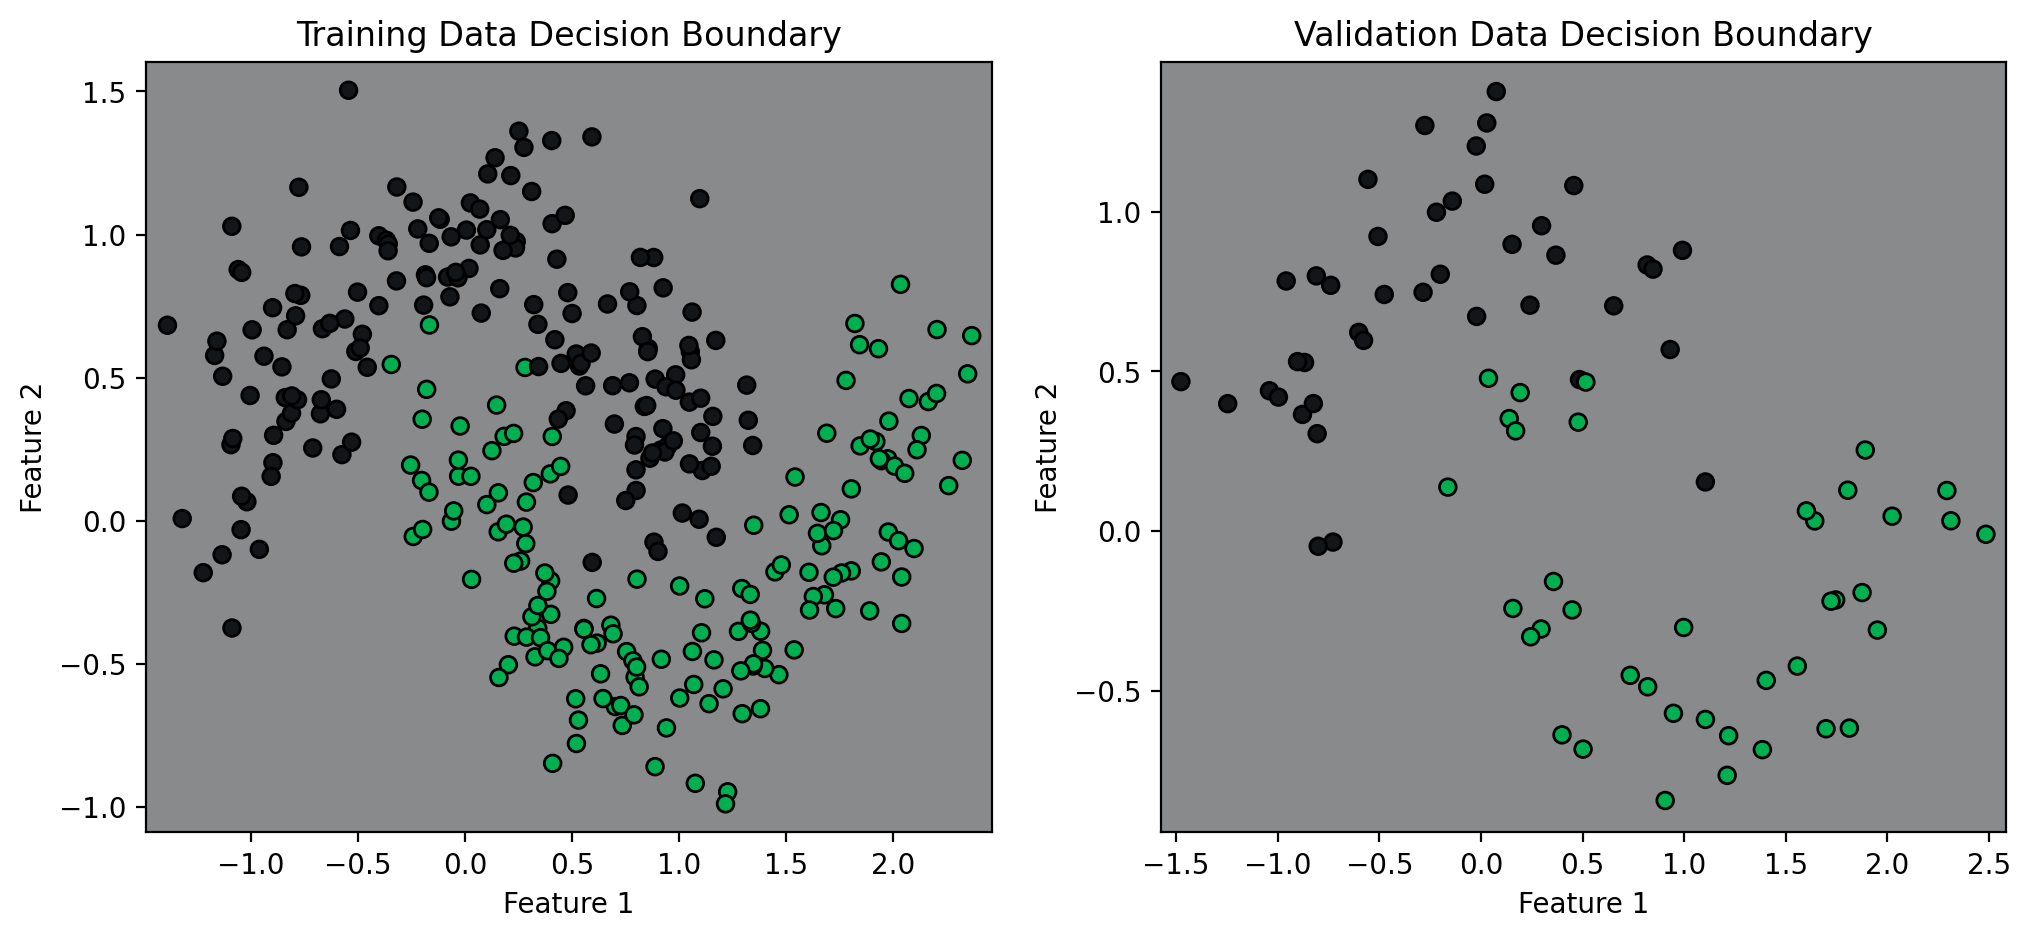

In [126]:
# Define the color with C map
color0 = "#121619"  # Dark grey
color1 = "#00B050"  # Green
color_map = ListedColormap([color0, color1])


# new decision boundary
def new_decision_boundary(
    nn, X, y, subplot, cmap=color_map, title="Decision Boundary"
):  # "Paired"
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.subplot(*subplot)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=color_map)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=color_map, edgecolor="k")  # plt.cm.Spectral
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)


plt.figure(figsize=(12, 5))

# Plot decision boundary on training data
new_decision_boundary(
    nn_best,
    X_train,
    y_train,
    subplot=(1, 2, 1),
    title="Training Data Decision Boundary",
)

# Plot decision boundary on validation data
new_decision_boundary(
    nn_best,
    X_val,
    y_val,
    subplot=(1, 2, 2),
    title="Validation Data Decision Boundary",
)

plt.show()

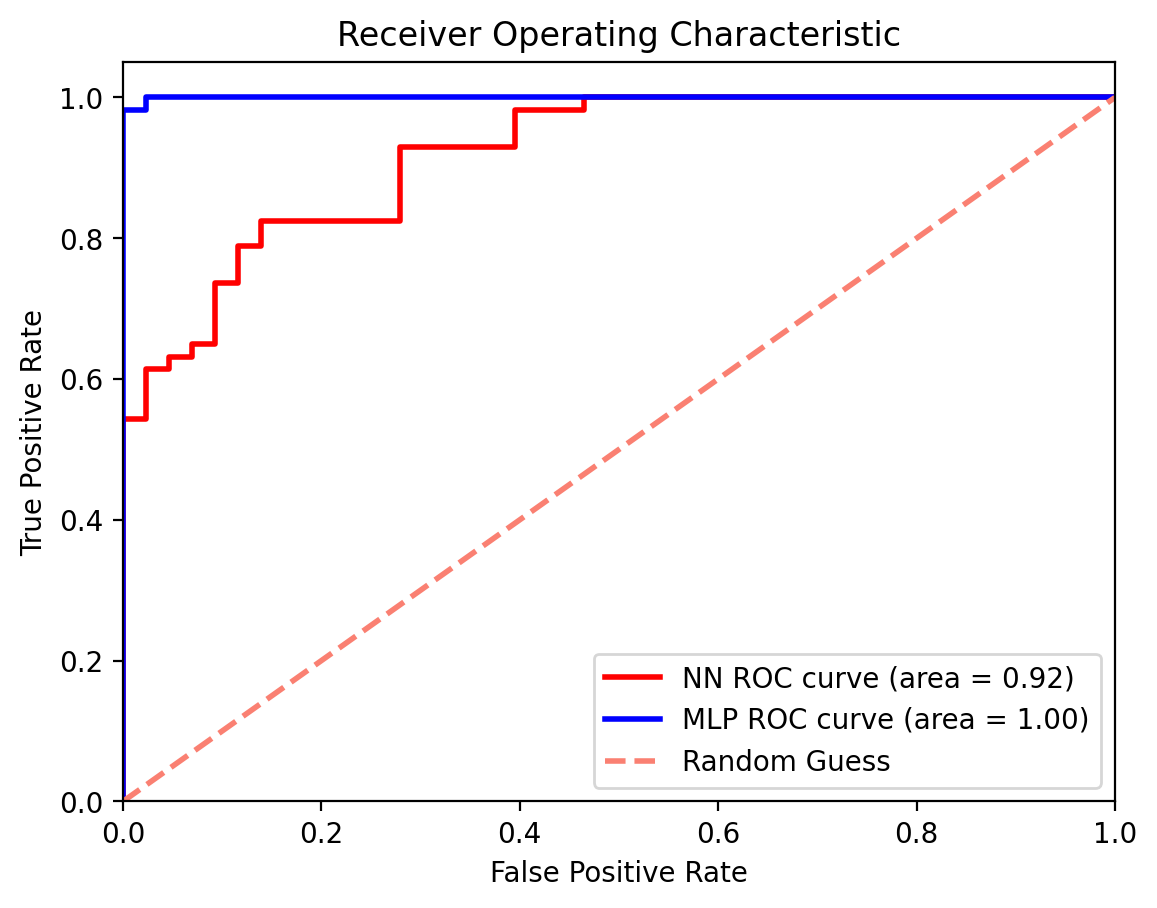

In [125]:
# neural network's predictions
y_scores_nn = nn_best.predict_proba(X_test)

# compute ROC curve and ROC area for your neural network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_scores_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Train scikit-learn MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(10, 5), max_iter=2000, learning_rate_init=0.1, random_state=42
)
mlp.fit(X_train, y_train)

# MLPClassifier predictions
y_scores_mlp = mlp.predict_proba(X_test)[:, 1]

# ROC curve and ROC area for MLPClassifier
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_scores_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# plot ROC curve
plt.figure()
plt.plot(
    fpr_nn,
    tpr_nn,
    color="red",
    lw=2,
    label=f"NN ROC curve (area = {roc_auc_nn:.2f})",
)
plt.plot(
    fpr_mlp,
    tpr_mlp,
    color="blue",
    lw=2,
    label=f"MLP ROC curve (area = {roc_auc_mlp:.2f})",
)
plt.plot([0, 1], [0, 1], color="salmon", lw=2, linestyle="--", label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

## (c)

>From the evaluation of questions (a) and (b), it is evident that my custom-trained neural network model achieves a performance comparable to the ``scikit-learn`` ``MLPClassifier``. However, the training process and model architecture have exposed certain issues. Notably, the training is constrained to a relatively low number of epochs; extending beyond 1000 epochs leads to dramatic and incorrect shifts in the loss curves. Furthermore, the decision boundary is not well-defined, despite the training and validation data appearing normal. A significant indicator of overfitting in my model is the MLP ROC curve, which achieves a value of 1. To mitigate these issues and enhance the model's performance, we could introduce regularization techniques such as Lasso Regression, which will help prevent overfitting by penalizing the magnitude of the weights. Applying Lasso Regression regularization involves choosing the right value for λ and integrating the penalty term with the existing loss function. During the training of the neural network, the regularized loss function now not only fits the data but also keeps the weights small, which helps in reducing overfitting and improving model's generalization. Also, we can think of using droupout technique.  This is particularly useful when dealing with overfitting. By randomly disabling neurons during training, dropout forces the network to learn more robust features that are not reliant on any small set of neurons. This typically leads to a model that generalizes better to new, unseen data. Additionally, implementing an early stopping protocol could curtail training before the model overfits, using the validation loss as a monitoring guide. These strategies are anticipated to correct the observed problems and lead to an improvement in the generalizability of the model.